# Plot ASKAP detections

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time
import csv
from astropy.io import ascii
import pandas as pd

Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline

In [2]:
def plot_continuum_cat(field, catalogues, centre):

    data_1 = pd.read_csv('/Users/denes/Research/high_lat_HI/ASKAP_data/continuum_cat/{}'.format(catalogues[0]))
    data_2 = pd.read_csv('/Users/denes/Research/high_lat_HI/ASKAP_data/continuum_cat/{}'.format(catalogues[1]))

    df_1 = pd.DataFrame(data_1)
    df_2 = pd.DataFrame(data_2)

    # concatenate catalogues
    df = pd.concat([df_1, df_2])

    # do a cut on the catalog

    sources = df[df['flux_peak']>15]
    print(len(sources))

    ra = np.array(sources['ra_hms_cont'])
    dec = np.array(sources['dec_dms_cont'])
    ra_deg = np.array(sources['ra_deg_cont'])
    dec_deg = np.array(sources['dec_deg_cont'])

    sources2 = pd.read_csv('./5_sigma_askap_sources_{}.csv'.format(field))

    ra2 = np.array(sources2['ra_hms_cont'])
    dec2 = np.array(sources2['dec_dms_cont'])
    ra_deg2 = np.array(sources2['ra_deg_cont'])
    dec_deg2 = np.array(sources2['dec_deg_cont'])

    # select continuum sources to plot

    coordinate = centre.replace(',', '')
    c = SkyCoord(coordinate, unit=(u.hourangle, u.deg))
    print(c)
    path_hi = SkyView.get_images(position=centre, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
    hdulist_hi = path_hi[0]
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header

    # plot figure
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection=WCS(h))

    # Display the moment map image
    im = ax.imshow(d, cmap='RdBu_r', vmax=np.percentile(d,99.9))
    #im = ax.imshow(d, cmap='bone_r', vmax=np.percentile(d,99.99))
    #ax.contour(co_reprojected, levels=[0.4, 0.8], cmap='Blues_r', alpha=0.7)

    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    ax.scatter(ra_deg, dec_deg, transform=ax.get_transform('fk5'), marker='x', s=100, c='k', linewidths=2)
    ax.scatter(ra_deg2, dec_deg2, transform=ax.get_transform('fk5'), marker='x', s=100, c='r', linewidths=3)

    #ax.set_title('Hydra', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

    cbar_hi = plt.colorbar(im, orientation='vertical', fraction=0.022, pad=0.12)
    cbar_hi.set_label('N(HI)', size=18)

    overlay = ax.get_coords_overlay('galactic')
    overlay.grid(color='k', ls='dotted')
    overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
    overlay[1].set_axislabel('Galactic Latitude', fontsize=22)
    overlay[0].tick_params(axis='both', which='major', labelsize=18)
    overlay[1].tick_params(axis='both', which='major', labelsize=18)

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    #plt.colorbar(im)
    fig.savefig('{}_ASKAP_continuum_sources_v2.png'.format(field),dpi=200)

598
<SkyCoord (ICRS): (ra, dec) in deg
    (249.5, -59.83333333)>


678
<SkyCoord (ICRS): (ra, dec) in deg
    (157.25, -27.59027778)>


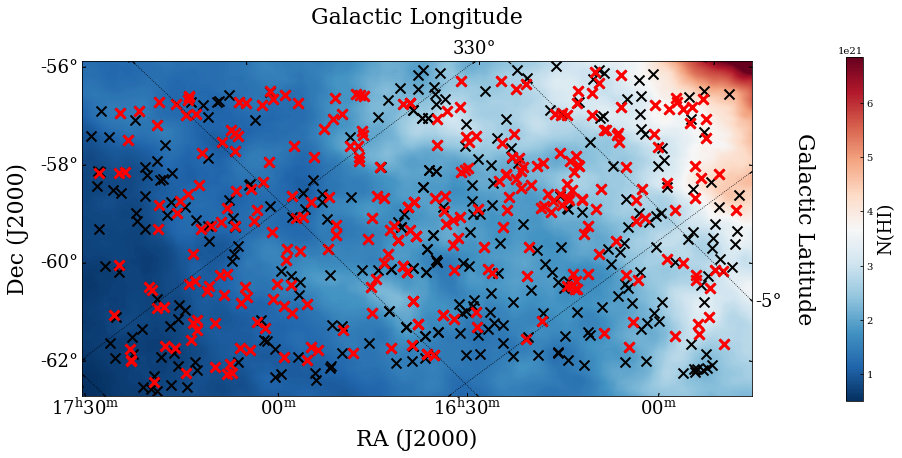

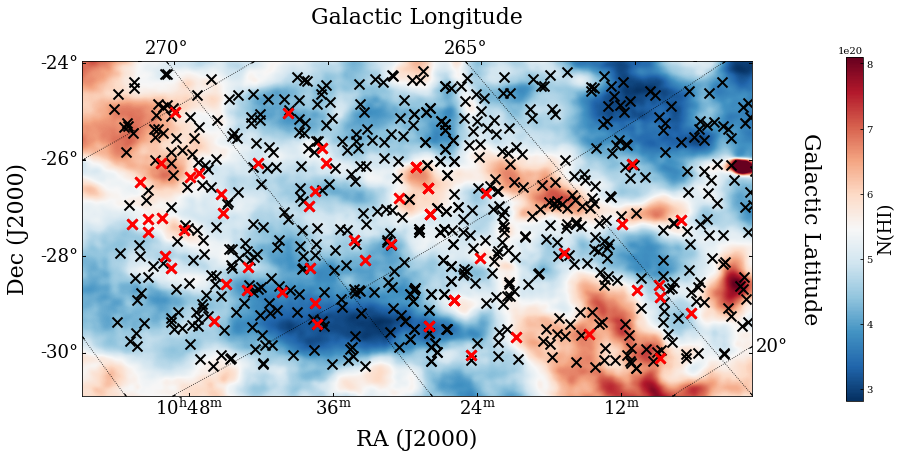

In [3]:
plot_continuum_cat('Norma', ['AS102_Continuum_Island_Catalogue_11816_3700.csv', 'AS102_Continuum_Island_Catalogue_12209_3734.csv'], '16:38:00, -59:50:00')
plot_continuum_cat('Hydra', ['AS102_Continuum_Island_Catalogue_10609_119.csv', 'AS102_Continuum_Island_Catalogue_10612_123.csv'], '10:29:00, -27:35:25')


# Plot tau and correction fraction

In [4]:
#field = 'Hydra'
field = 'Norma'
sources = pd.read_csv('./5_sigma_askap_sources_with_GASS_data_{}.csv'.format(field))

ra = np.array(sources['ra_hms_cont'])
dec = np.array(sources['dec_dms_cont'])
ra_deg = np.array(sources['ra_deg_cont'])
dec_deg = np.array(sources['dec_deg_cont'])
r = np.array(sources['correction_fraction'])

print(sources.keys())

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'catalogue_id', 'other_sbids',
       'first_sbid', 'project_id', 'island_id', 'island_name', 'n_components',
       'ra_hms_cont', 'dec_dms_cont', 'ra_deg_cont', 'dec_deg_cont', 'freq',
       'maj_axis', 'min_axis', 'pos_ang', 'flux_int', 'flux_int_err',
       'flux_peak', 'mean_background', 'background_noise', 'max_residual',
       'min_residual', 'mean_residual', 'rms_residual', 'stddev_residual',
       'x_min', 'x_max', 'y_min', 'y_max', 'n_pix', 'solid_angle', 'beam_area',
       'x_ave', 'y_ave', 'x_cen', 'y_cen', 'x_peak', 'y_peak', 'flag_i1',
       'flag_i2', 'flag_i3', 'flag_i4', 'comment', 'quality_level',
       'released_date', 'rms_abs', 'tau_max', 'min_askap',
       'correction_fraction'],
      dtype='object')


<SkyCoord (ICRS): (ra, dec) in deg
    (249.5, -59.83333333)>


/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releas

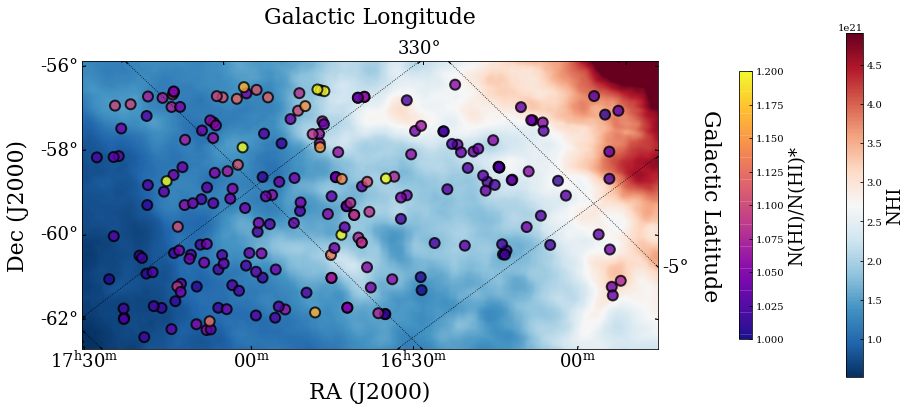

In [5]:
centre = '16:38:00, -59:50:00'
coordinate = centre.replace(',', '')
c = SkyCoord(coordinate, unit=(u.hourangle, u.deg))
print(c)
path_hi = SkyView.get_images(position=centre, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi = path_hi[0]
d = hdulist_hi[0].data
h = hdulist_hi[0].header

#co_data = fits.open('/Users/denes/Research/high_lat_HI/Planck_CO/Rep_Lon327.39deg-Lat-7.76deg_15deg_COM_CompMap_CO21-commander_2048_R2.00.fits')  # Open the FITS file for reading
#d2 = co_data[1].data
#h2 = co_data[1].header

#co_reprojected, footprint = reproject_interp(co_data[1], h)

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection=WCS(h))

# Display the moment map image
im = ax.imshow(d, cmap='RdBu_r', vmax=np.percentile(d,99))
#im = ax.imshow(d, cmap='Greys', vmax=np.percentile(d,99))
#ax.contour(co_reprojected, levels=[0.4, 0.8, 1.6], cmap='Reds', alpha=0.7)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

im2 = ax.scatter(ra_deg, dec_deg, transform=ax.get_transform('fk5'), marker='o', s=100, linewidth=2, edgecolor='k', c=r, cmap='plasma', vmin=1, vmax=1.2, alpha=0.8)


#ax.set_title('Norma', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)
cbar_hi = plt.colorbar(im, orientation='vertical', fraction=0.022, pad=0.12)
cbar_hi.set_label('NHI', size=18)
cbar_hi2 = plt.colorbar(im2, orientation='vertical', fraction=0.02, pad=0.12)
cbar_hi2.set_label('N(HI)/N(HI)*', size=18)

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='k', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
overlay[1].set_axislabel('Galactic Latitude', fontsize=22)
overlay[0].tick_params(axis='both', which='major', labelsize=18)
overlay[1].tick_params(axis='both', which='major', labelsize=18)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)


#plt.colorbar(im)
fig.savefig('Norma_HI4PI_overlay_cold_fraction.png',dpi=200)

<SkyCoord (ICRS): (ra, dec) in deg
    (157.25, -27.59027778)>


/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releas

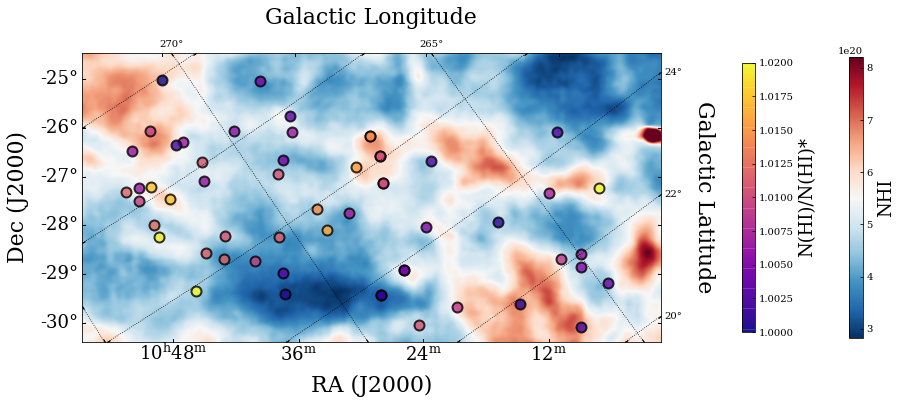

In [81]:
field = 'Hydra'
#field = 'Norma'
sources = pd.read_csv('./5_sigma_askap_sources_with_GASS_data_{}.csv'.format(field))

ra = np.array(sources['ra_hms_cont'])
dec = np.array(sources['dec_dms_cont'])
ra_deg = np.array(sources['ra_deg_cont'])
dec_deg = np.array(sources['dec_deg_cont'])
r = np.array(sources['correction_fraction'])

centre = '10:29:00, -27:35:25'
coordinate = centre.replace(',', '')
c = SkyCoord(coordinate, unit=(u.hourangle, u.deg))
print(c)
path_hi = SkyView.get_images(position=centre, width=12*u.deg, height=6*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi = path_hi[0]
d = hdulist_hi[0].data
h = hdulist_hi[0].header

#co_data = fits.open('/Users/denes/Research/high_lat_HI/Planck_CO/Rep_Lon264.69deg-Lat23.29deg_15deg_COM_CompMap_CO21-commander_2048_R2.00_v2.fits')  # Open the FITS file for reading
#print(co_data[1].shape)
#d2 = co_data[1].data
#h2 = co_data[1].header

#co_reprojected, footprint = reproject_interp(co_data[1], h)

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection=WCS(h))

# Display the moment map image
im = ax.imshow(d, cmap='RdBu_r', vmax=np.percentile(d,99.9))
#ax.contour(co_reprojected, levels=[0.4, 0.8], cmap='Reds', alpha=0.7)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

for i in range(0, len(ra)):
    c = SkyCoord(ra[i], dec[i], unit=(u.hourangle, u.deg))
    im2 = ax.scatter(c.ra, c.dec, transform=ax.get_transform('fk5'), marker='o', s=100, linewidth=2, edgecolor='k', c=r[i], cmap='plasma', vmin=1, vmax=1.02, alpha=0.8)

#ax.set_title('Hydra', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)
cbar_hi = plt.colorbar(im, orientation='vertical', fraction=0.018, pad=0.12)
cbar_hi.set_label('NHI', size=18)
cbar_hi2 = plt.colorbar(im2, orientation='vertical', fraction=0.02, pad=0.12)
cbar_hi2.set_label('N(HI)/N(HI)*', size=18)

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='k', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
overlay[1].set_axislabel('Galactic Latitude', fontsize=22)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)


#plt.colorbar(im)
fig.savefig('Hydra_HI4PI_overlay_v2.png',dpi=200)

# Do plots with multiple data sets (Norma+Hydra)
- histograms
- scatter plots

In [16]:
sources_h = pd.read_csv('./5_sigma_askap_sources_with_GASS_data_Hydra.csv'.format(field))
sources_n = pd.read_csv('./5_sigma_askap_sources_with_GASS_data_Norma.csv'.format(field))

ra_deg_h = np.array(sources_h['ra_deg_cont'])
dec_deg_h = np.array(sources_h['dec_deg_cont'])
r_h = np.array(sources_h['correction_fraction'])
tau_max_h = np.array(sources_h['tau_max'])

ra_deg_n = np.array(sources_n['ra_deg_cont'])
dec_deg_n = np.array(sources_n['dec_deg_cont'])
r_n = np.array(sources_n['correction_fraction'])
tau_max_n = np.array(sources_n['tau_max'])

In [82]:
print(np.mean(r_n))
print(np.mean(r_h))
print(np.mean(tau_max_n))
print(np.mean(tau_max_h))

1.0547098927306817
1.008429243925833
0.4803787329169207
0.11179016760018255


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.


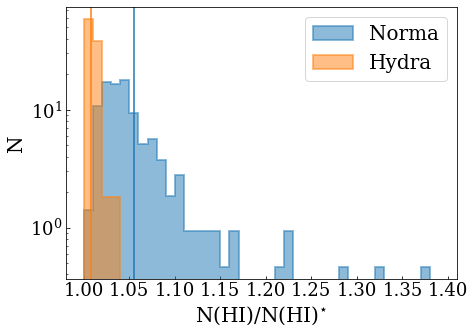

In [38]:
fig = plt.figure(figsize=(7.,5.))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

bins = np.arange(1,1.4,0.01)

ax = fig.add_subplot(1,1,1)
plt.hist(r_n, bins=bins, histtype='step', color='C0', Fill=True, density=True, alpha=0.5, linewidth=2, log=True, label='Norma')
plt.hist(r_h, bins=bins, histtype='step', color='C1', Fill=True, density=True, alpha=0.5, linewidth=2, log=True, label='Hydra')
ax.axvline(np.mean(r_n), color='C0')
ax.axvline(np.mean(r_h), color='C1')
plt.xticks(family='serif',size=18)
plt.yticks(family='serif',size=18)
#ax.set_ybound(0, 20)
ax.set_xlabel(r'N(HI)/N(HI)$^{\star}$', size=20,family='serif')
ax.set_ylabel('N', size=20,family='serif')
plt.legend(fontsize=20)

plt.savefig('r_hist_5sig.png', bbox_inches='tight', dpi=200)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.


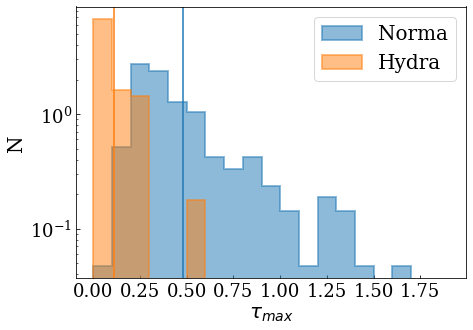

In [78]:
fig = plt.figure(figsize=(7.,5.))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

bins = np.arange(0,2,0.1)

ax = fig.add_subplot(1,1,1)
plt.hist(tau_max_n, bins=bins, histtype='step', color='C0', Fill=True, density=True, alpha=0.5, linewidth=2, log=True, label='Norma')
plt.hist(tau_max_h, bins=bins, histtype='step', color='C1', Fill=True, density=True, alpha=0.5, linewidth=2, log=True, label='Hydra')
ax.axvline(np.mean(tau_max_n), color='C0')
ax.axvline(np.mean(tau_max_h), color='C1')
plt.xticks(family='serif',size=18)
plt.yticks(family='serif',size=18)
#ax.set_ybound(0, 20)
ax.set_xlabel(r'$\tau_{max}$', size=20,family='serif')
ax.set_ylabel('N', size=20,family='serif')
plt.legend(fontsize=20)

plt.savefig('tau_max_hist_5sig.png', bbox_inches='tight', dpi=200)


# Plots with b

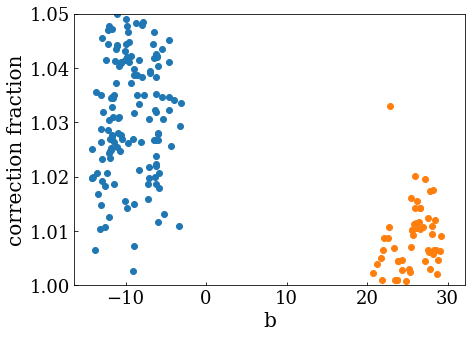

In [46]:
c_ar_n = SkyCoord(ra_deg_n, dec_deg_n, unit=(u.deg, u.deg))
c_ar_h = SkyCoord(ra_deg_h, dec_deg_h, unit=(u.deg, u.deg))

fig = plt.figure(figsize=(7.,5.))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(1,1,1)

plt.plot(c_ar_n.galactic.b.deg, r_n, 'o', color='C0')
plt.plot(c_ar_h.galactic.b.deg, r_h, 'o', color='C1')
plt.ylim(1,1.05)

plt.xticks(family='serif',size=18)
plt.yticks(family='serif',size=18)
#ax.set_ybound(0, 20)
ax.set_xlabel('b', size=20,family='serif')
ax.set_ylabel('correction fraction', size=20,family='serif')

plt.savefig('correction_fraction_b.png'.format(field), bbox_inches='tight', dpi=200)
